파라미터 찍기용 (TP_learnable)

In [1]:
# 사전 변수
checkpoint_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_TP_learnable_2024-12-29-21-57-05_fold1_lastEpoch.pt"
config_json_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_TP_learnable_2024-12-29-21-57-05_fold1_config.json"

savefile_name = "params_TP_learnable.svg"



In [2]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

from sklearn.model_selection import KFold # cross-validation용

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

2025-06-02 09:34:05.890251: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 09:34:05.942359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 09:34:06.720421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# 환경설정
with open(config_json_dir, 'r') as f:
    print("config.json파일 읽기 성공!")
    json_data = json.load(f)

cuda_gpu = json_data['cuda_gpu']
model_name = json_data['model_name']
num_classes = json_data['num_classes']
num_encoders = json_data['num_encoders']
early_stop = json_data['early_stop']
early_stop_enable = json_data['early_stop_enable']
learning_rate = json_data['init_lr']
batch_size = json_data['batch_size']
num_epochs = json_data['num_epochs']
train_path = json_data['train_path']
test_path = json_data['test_path']
class_weight = json_data['class_weight']
encoder_min = json_data['encoder_min']
encoder_max = json_data['encoder_max']
hidden_size = json_data['hidden_size']
hidden_size_2 = json_data['hidden_size_2']
scheduler_tmax = json_data['scheduler_tmax']
scheduler_eta_min = json_data['scheduler_eta_min']
encoder_requires_grad = json_data['encoder_requires_grad']
encoder_type = json_data['encoder_type']
encoder_tp_iter_repeat = json_data['encoder_tp_iter_repeat']
random_seed = json_data['random_seed']
checkpoint_save = json_data['checkpoint_save']
checkpoint_path = json_data['checkpoint_path']
threshold_value = json_data['threshold_value']
reset_value_residual = json_data['reset_value_residual']
need_bias = json_data['need_bias']
k_folds = json_data['k_folds']


# Cuda 써야겠지?
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # GPU 번호별로 0번부터 나열
os.environ["CUDA_VISIBLE_DEVICES"]= str(cuda_gpu)  # 상황에 맞춰 변경할 것
device = "cuda" if torch.cuda.is_available() else "cpu" # 연산에 GPU 쓰도록 지정
print("Device :" + device) # 확인용
# input() # 일시정지용

# 랜덤시드 고정
seed = random_seed
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
      

# TP_learnable 모델
class SNN_MLP(nn.Module):
    def __init__(self, num_classes, hidden_size, hidden_size_2, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # SNN 인코더 : 채널 크기만큼 확장하기
        self.encoder = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(1, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

        # SNN 리니어 : 인코더 출력 -> 히든
        self.hidden = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size, hidden_size_2, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
        

        # SNN 리니어 : 히든 -> 출력
        self.layer = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size_2, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

    def forward(self, x: torch.Tensor):
        results = 0. # for문이 모델 안에 있으므로 밖에다가는 이녀석을 내보내야 함
        # print(x.shape) # (배치크기, 187) 모양임
        
        timestep_size = x.shape[1] # 187 timestep을 만들어야 함
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,i].squeeze().unsqueeze(1) # 슬라이스 진행 후 256, 1 크기가 되도록 shape 수정
            x_slice = self.encoder(x_slice)
            x_slice = self.hidden(x_slice)
            x_slice = self.layer(x_slice)
            results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)
        # results = torch.stack(results, dim=0) # 텐서로 바꾸기
        return results / timestep_size

# 데이터 가져오는 알맹이 클래스
class MITLoader_MLP_binary(Dataset):

    def __init__(self, csv_file, transforms: Callable = lambda x: x) -> None:
        super().__init__()
        self.annotations = pd.read_csv(csv_file).values
        self.transforms = transforms

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, item):
        signal = self.annotations[item, :-1]
        signal = torch.from_numpy(signal).float()
        if self.transforms : 
            signal = self.transforms(signal)
        
        label = int(self.annotations[item, -1])
        if label > 0:
            label = 1  # 1 이상인 모든 값은 1로 변환(난 이진값 처리하니깐)

        return signal, torch.tensor(label).long()
    

config.json파일 읽기 성공!
Device :cuda


In [4]:


# 모델 로드 함수 정의
def load_model(checkpoint_path_, model):
    checkpoint = torch.load(checkpoint_path_)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # 평가 모드로 전환
    return model


# 모델, 로더 지정
dataset = MITLoader_MLP_binary(csv_file=test_path)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last = True)

# SNN 네트워크 초기화
model = SNN_MLP(num_classes = num_classes, hidden_size=hidden_size, hidden_size_2=hidden_size_2, threshold_value=threshold_value, 
                bias_option=need_bias, reset_value_residual=reset_value_residual).to(device=device)

# 모델 로드
model = load_model(checkpoint_dir, model)




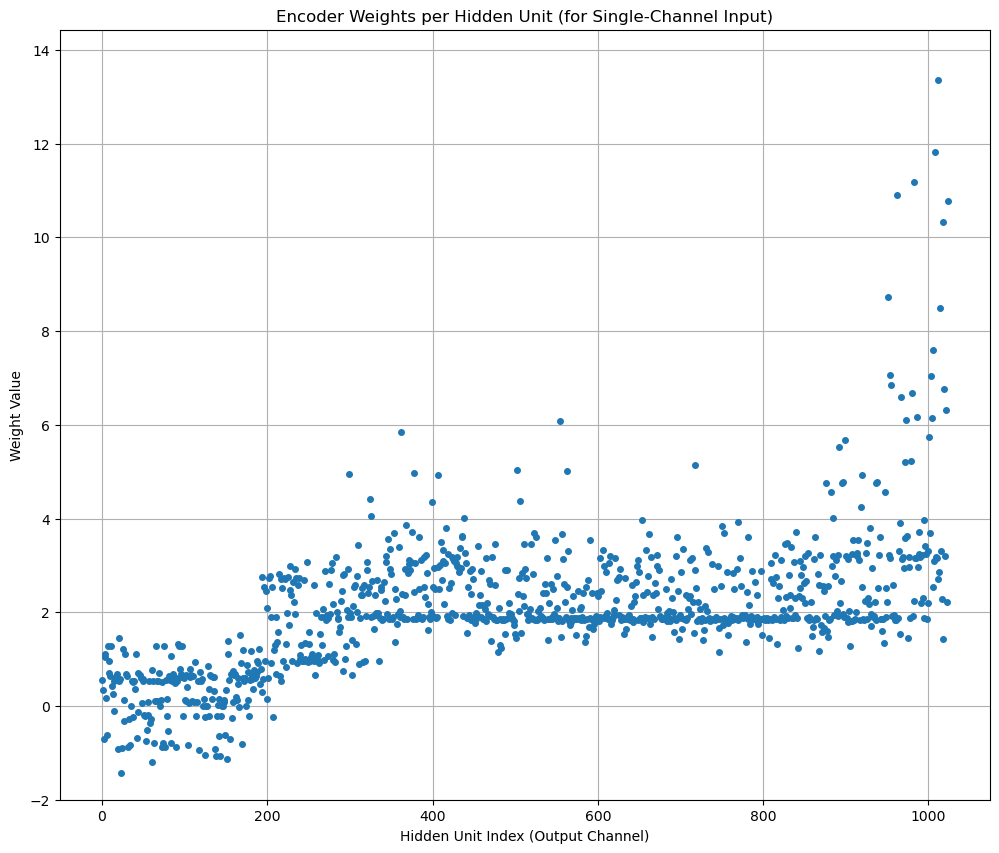

In [7]:
# encoder 가중치 불러오기
weights = model.encoder[0].weight.detach().cpu().numpy()

# 입력 채널이 1개일 경우, shape: (hidden_size, 1) -> flatten
if weights.shape[1] == 1:
    weights = weights.squeeze(1)

# x축: Hidden Unit 인덱스 (출력 채널)
x = range(len(weights))

# Plot 그리기
plt.figure(figsize=(12, 10))
plt.plot(x, weights, marker='o', markersize=4, linestyle='None')  # 점 크기를 4로 설정
plt.ylim(-2, None)  # y축 범위 설정 (0.2부터 시작)
plt.xlabel('Hidden Unit Index (Output Channel)')
plt.ylabel('Weight Value')
plt.title('Encoder Weights per Hidden Unit (for Single-Channel Input)')
plt.grid(True)

plt.savefig(savefile_name, format="svg", bbox_inches="tight")
plt.show()
plt.close()